# Homework 3 - Marija Zelic, 371271

In this homework, we are going to work with the transformer. There are three parts of this homework.

- In the first part, we are going to implement **positional encoding** and **self-attention**  and test them on a simple text dataset which contains around 100 sentences. We will use a small transformer in this task.

- In the second part, we will detect promoters from the DNA sequences. The main difference compared to the previous task is to tokenize the DNA sequence. Thus, our task here is to build the **tokenizer** to tokenize the DNA sequence. For the model, we will continue using the small transformer.

- In the third part, we will use a **foundation model** DNABERT to perform promoter detection. In this part, you do not need to train the transformer. Instead, you need to find and load the correct pre-trained model and then use it to get the embedding of the DNA sequence. Then, you will build a simple classifier to perform promoter detection based on the DNA embedding.



## 0. Initialization

Import the packages you are going to use here.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import random
import numpy as np
from torchmetrics.classification import BinaryF1Score
import sys

import ipywidgets as widgets
from types import SimpleNamespace
from utils import data, evaluation, models, visualization, text_exercise

import math

from transformers import logging

logging.set_verbosity_error() # set this so it would not notify you every time that you should train it for specific task

Set the hyperparameters.

In [2]:
# Set seeds
seed = 128
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Positional Encoding and Self-Attention (7 pts)

### 1.1. Sinusoidal Positional Encoding (1 pt)

In this section, you are going to implement the sinusoidal positional encoding. The formula is as the following:

<div>
<img src="imgs/positional embedding.png" width="400"/>
</div>

where $t$ is the desired position in the input and $\mathsf{\omega}_k$ follows:

<div>
<img src="imgs/omega.png" width="200"/>
</div>

To see the details of sinusoidal positional encoding, you can check this [link](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/).

In [3]:
class PositionalEmbedding(nn.Module):

    def __init__(self, max_position_embeddings, hidden_size, device):
        super().__init__()

        '''
        max_position_embeddings: maximum length of the input - related to t in the previous formula
        hidden_size: encoding dimension - d in the previous formula
        '''
        # Making matrix of shape (max_position_embeddings, hidden_size), displayed below
        # [0, ..., 0]
        # [1, ..., 1]
        # ....
        # [mpe-1, ..., mpe-1]
        t = torch.arange(max_position_embeddings)
        t = t.repeat(hidden_size, 1)
        t = torch.transpose(t, 0, 1)


        # Making w_k values
        k = torch.arange(hidden_size/2)
        k = (-2) * torch.repeat_interleave(k, 2) / hidden_size
        w_k = torch.pow(10000., k)

        # Create positional embeddings
        self.positional_embedding = t * w_k
        even_indices = torch.arange(0, hidden_size, 2)
        odd_indices = torch.arange(1, hidden_size, 2)

        # Apply sine on columns with even indexes and cosine on columns with odd indexes
        self.positional_embedding[:, even_indices] = torch.sin(self.positional_embedding[:, even_indices])
        self.positional_embedding[:, odd_indices] = torch.cos(self.positional_embedding[:, odd_indices])


    def forward(self, x):
        return self.positional_embedding[:x.size(1), :]

    def embedding(self):
        return self.positional_embedding

Here, you can visualize your positional encoding. If you implement everything correctly, you can get a figure that is similar to Figure 2 in this [link](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/).

In [4]:
visualize_embedding, dimension_selector, max_len_selector = visualization.display_positional_encoding(PositionalEmbedding)
ui = widgets.HBox([max_len_selector, dimension_selector])
out = widgets.interactive_output( visualize_embedding, {'max_len': max_len_selector, 'dimension': dimension_selector})
display(ui, out)

Output()

### 1.2. Self-Attention Mechanism (5 pts)

In this section, you are going to implement the self-attention mechanism. Please check the section 'Self-Attention in Detail' in this [link](https://jalammar.github.io/illustrated-transformer/) for the details of self-attention mechanism. (We encourage you to carefully go through the link since it is a very good tutorial for transformer.)

The specific steps will be provided in the comments of the following code. (The steps are only for reference. You do need to follow the steps if you have a better way to implement it.)

Let's test your implementation using simple text data! First, let's load the data.

We use a small dataset in this homework for a shorter training time.

In [5]:
class BertSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        if config.hidden_size % config.num_attention_heads != 0:
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (config.hidden_size, config.num_attention_heads)
            )
        self.output_attentions = config.output_attentions
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        # ToDo: initialize K, Q, V
        self.query = nn.Linear(config.hidden_size, self.all_head_size, bias=False)
        self.key = nn.Linear(config.hidden_size, self.all_head_size, bias=False)
        self.value = nn.Linear(config.hidden_size, self.all_head_size, bias=False)

        # ToDo: add a dropout layer
        # Hint: using config.attention_probs_dropout_prob as the dropout probability
        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
    ):
        # The parameter encoder_hidden_states and encoder_attention_mask is for cross-attention. 
        # We do not use them in this homework.

        # ToDo: get the key, query, and value from the hidden_states
        mixed_key_layer = self.key(hidden_states)
        mixed_query_layer = self.query(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        # ToDo: transpose K, Q, V to get the score
        # Hint: using self.transpose_for_scores
        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        # ToDo: Get the raw attention score
        # Hint: Lecture 05 transformers - Slide 23 - the part within the softmax
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        
        # You do not need to change this part.
        # Explanation of attention_mask: https://lukesalamone.github.io/posts/what-are-attention-masks/
        if attention_mask is not None:
            attention_scores = attention_scores + attention_mask

        # ToDo: Normalize the attention scores to probabilities.
        # Hint: 
        # 1. Lecture 05 transformers - Slide 23 - using softmax to get the probability
        # 2. Use self.dropout to do the dropout

        attention_probs = nn.Softmax(dim=-1)(attention_scores)
        attention_probs = self.dropout(attention_probs)

        # You do not need to change this part.
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        # ToDo: Multiply each value by the score
        # Hint: 
        # 1. Lecture 05 transformers - Slide 23 - getting the final result
        # 2. Permuting the result to the correct shape. If you do not know what should be the correct shape, you can print the shape of the tensors.
        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        
        # Get the output
        outputs = (context_layer, attention_probs) if self.output_attentions else (context_layer,)
        return outputs

In [6]:
# ChatGPT generated text data about BERT
text = text_exercise.get()
sentences_df, vocab = data.to_sentence_df(text)

After loading the data, you can train your model. Here we train our model using masked token prediction.

Hint: The final model accuracy should be higher than 0.9.

In [7]:
text_max_len = 11

text_config = SimpleNamespace(
        vocab_size=len(vocab),
        hidden_size=60,
        max_position_embeddings=text_max_len,
        type_vocab_size=1,
        layer_norm_eps=1e-12,
        hidden_dropout_prob=0.0,
        attention_probs_dropout_prob=0.0,
        num_attention_heads=1,
        hidden_act="gelu",
        intermediate_size=160,
        num_hidden_layers=1,
        is_decoder=False,
        output_attentions=True,
        output_hidden_states=False,
        pruned_heads = {},
        initializer_range=0.02,
        device="cpu"
    )

tokenizer = data.TextTokenizer(vocab)
input_ids, segment_ids, masked_lm_labels, labels_idx, labels, attention_masks = data.generate_masked_data(sentences_df, tokenizer, k=1, max_len=text_max_len, noise_rate=0.4)

In [8]:
model = models.BertForMaskedLM(config=text_config, positional_embedding=PositionalEmbedding, attention=BertSelfAttention)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
print(f"Number of trainable model parameters: {models.number_of_model_parameters(model)}")

for epoch in range(200):
    optimizer.zero_grad()
    loss, outputs, attentions = model(
        input_ids=input_ids,
        token_type_ids=segment_ids,
        masked_lm_labels=masked_lm_labels,
        attention_mask=attention_masks
    )
    if (epoch + 1) % 20 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(loss))
    loss.backward()
    optimizer.step()

print(f"Final model accuracy: {evaluation.masked_label_accuracy(labels, labels_idx, outputs.data)}")

Number of trainable model parameters: 64730
Epoch: 0020 loss = 4.301435
Epoch: 0040 loss = 3.687816
Epoch: 0060 loss = 3.129095
Epoch: 0080 loss = 2.624837
Epoch: 0100 loss = 2.151881
Epoch: 0120 loss = 1.704488
Epoch: 0140 loss = 1.300868
Epoch: 0160 loss = 0.950828
Epoch: 0180 loss = 0.666645
Epoch: 0200 loss = 0.445623
Final model accuracy: 0.9922480620155039


### 1.3. Visualize Attention (1 pt)

Here, you can visualize the self-attention.

Question: Can you interpret the visualization of the self-attention?

**Write down you answer here (1 pt):**

In [9]:
visualize_attention, sample_id_selector = visualization.display_attantion(attentions=attentions, input_ids=input_ids, tokenizer=tokenizer)
widgets.interactive(visualize_attention, sample_id=sample_id_selector)

interactive(children=(Dropdown(description='Sample:', options=(5, 8, 11, 13, 18, 24, 26, 29, 31, 35, 37, 38, 6…

**Answer:** In the table above attention weight matrix is displayed. The attention weight matrix measures the "strenght" of relationship between a word in a sentence and every other word in the same sentence. As we can see in the table above, we are looking at the fifth sample, which is the sentence *"Now, it's much easier because of transformers."*. As we set maximum lenght for the sentence to be 11, by the parameter *text_max_len*, the remaining words to the maximum lenght are padded (indicated by the 'PAD' in the table). Also, we are using masked token prediction, so some of the tokens are masked (labeled with the 'MASK' in the table). It can be inferred that the strongest relationship exists bewteen *now* and *it's* tokens with the other words (especially masked ones) and that can be attributed to various reasons, such as postitonal and contextual information masked words provide and the critical importance of the begining and end of the sentence in general.

### 1.4. Train on small Wikitext Dataset

Here, you can **optionally** test your model on the smallest wikitext dataset. You should get an test accuracy around 0.4 after training 50 epochs.

This part is only for you to test your code. You can choose to run it or not. It takes around 1 hour to train the model for 50 epochs on the smallest wikitext dataset with Google Colab.

In [10]:
#text_exercise.train_wikitext(device, positional_embedding=PositionalEmbedding, attention=BertSelfAttention)

## 2. Promoter detection (7 pts)

In this section, we detect promoter in DNA sequence.

A promoter is a region of DNA upstream of a gene where relevant proteins (such as RNA polymerase and transcription factors) bind to initiate transcription of that gene. Promoter detection is to identify if there are promoter regions in the given DNA sequence. We have covered this in the lecture. (If you are interested in the promoter, you can check this [link](https://www.genome.gov/genetics-glossary/Promoter) for more details.)

Here, we use a transformer and a classifier. The transformer first embeds the DNA sequences into features, and then the classifier detects the promoter based on the features.

The main difference between text and DNA sequence is how to tokenize the sequence. Thus, you need to implement a tokenizer for the DNA sequence.

In [11]:
class DNATokenizer(data.Tokenizer):
    def __init__(self, k, vocab, unknown="[UNK]"):
        super().__init__(vocab, unknown)

        # self.k is the k of k-mers
        self.k = k

    def _parse_text(self, text):

        # ToDo: get the tokens
        output = []
        for i in range(len(text) - (self.k-1)):
            output.append(text[i:i+self.k])

        output.insert(0, '[CLS]')
        output.append('[SEP]')
        return output

In [12]:
kmer = 3
mask_length = kmer
VOCAB_3MER = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]", "AAA", "AAT", "AAC", "AAG", "ATA", "ATT", "ATC", "ATG", "ACA", "ACT", "ACC", "ACG", "AGA", "AGT", "AGC", "AGG", "TAA", "TAT", "TAC", "TAG", "TTA", "TTT", "TTC", "TTG", "TCA", "TCT", "TCC", "TCG", "TGA", "TGT", "TGC", "TGG", "CAA", "CAT", "CAC", "CAG", "CTA", "CTT", "CTC", "CTG", "CCA", "CCT", "CCC", "CCG", "CGA", "CGT", "CGC", "CGG", "GAA", "GAT", "GAC", "GAG", "GTA", "GTT", "GTC", "GTG", "GCA", "GCT", "GCC", "GCG", "GGA", "GGT", "GGC", "GGG" ]

raw_training_data = data.load_csv("./data/train.csv")
raw_test_data = data.load_csv("./data/test.csv")
dna_max_len = 300
batch_size = 128
max_dna_mask = 100
dataset_size = 1000
num_layers = 3
num_heads = 6
dna_config = SimpleNamespace(
        vocab_size=len(VOCAB_3MER),
        hidden_size=60,
        max_position_embeddings=dna_max_len,
        type_vocab_size=1,
        layer_norm_eps=1e-12,
        hidden_dropout_prob=0.0,
        attention_probs_dropout_prob=0.0,
        num_attention_heads=num_heads,
        hidden_act="gelu",
        intermediate_size=160,
        num_hidden_layers=num_layers,
        is_decoder=False,
        output_attentions=True,
        output_hidden_states=True,
        pruned_heads = {},
        initializer_range=0.02,
        device=device
    )

### 2.2. Test BERT on DNA Sequence

In this section, you will train BERT on DNA sequence to learn the embedding of DNA sequence. The code is provided below and you do not need to write anything.

Hint: the final evaluation accuracy should be higher than 0.2.  

**NOTE** : I added ['CLS'] and ['SEP'] tokens in the tokenization procedure, so the parameter *dna_mask* had to be increased from 298 to 300. ['CLS'] token is often used when BERT pretrained model is used for sequence classification task.

In [13]:
tokenizer = DNATokenizer(k=kmer, vocab=VOCAB_3MER)
input_ids, segment_ids, masked_lm_labels, labels_idx, labels, attention_masks = data.generate_masked_data(raw_training_data, tokenizer, max_len=dna_max_len, max_mask=max_dna_mask, k=mask_length, mask_rate=0.05, max_size=dataset_size)
test_input_ids, test_segment_ids, test_masked_lm_labels, test_labels_idx, test_labels, test_attention_masks = data.generate_masked_data(raw_test_data, tokenizer, max_len=dna_max_len, max_mask=max_dna_mask, k=mask_length, mask_rate=0.05, max_size=dataset_size)
model = models.BertForMaskedLM(config=dna_config, positional_embedding=PositionalEmbedding, attention=BertSelfAttention).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.005)
print(f"Number of trainable model parameters: {models.number_of_model_parameters(model)}")

train_dataset = TensorDataset(input_ids, segment_ids, masked_lm_labels, labels_idx, labels, attention_masks)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_input_ids, test_segment_ids, test_masked_lm_labels, test_labels_idx, test_labels, test_attention_masks)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Number of trainable model parameters: 118329


In [14]:
for epoch in range(50):
  total_train_loss = 0
  model.train()
  for batch_input_ids, batch_segment_ids, batch_masked_lm_labels, _, _, batch_attention_mask in train_loader:
    optimizer.zero_grad()
    loss, outputs, hidden_states, _ = model(
        input_ids=batch_input_ids.to(device),
        token_type_ids=batch_segment_ids.to(device),
        masked_lm_labels=batch_masked_lm_labels.to(device),
        attention_mask=batch_attention_mask.to(device)
    )
    #print(hidden_states[1].size())
    #check = hidden_states[1]
    #check_new = check[:, 0, :]
    #print(check_new.size())
    loss.backward()
    optimizer.step()
    total_train_loss += loss.item()
  avg_train_loss = total_train_loss / len(train_loader)

  if (epoch + 1) % 10 == 0:
    model.eval()
    total_eval_loss = 0
    for batch_input_ids, batch_segment_ids, batch_masked_lm_labels, _, _, batch_attention_mask in test_loader:
      with torch.no_grad():
        loss, outputs, hidden_states, _ = model(
          input_ids=batch_input_ids.to(device),
          token_type_ids=batch_segment_ids.to(device),
          masked_lm_labels=batch_masked_lm_labels.to(device),
          attention_mask=batch_attention_mask.to(device)
        )
        if batch_attention_mask.sum() - torch.numel(batch_attention_mask) > 0 :
          print("found patting", batch_attention_mask.sum())
        total_eval_loss += loss.item()
    avg_eval_loss = total_eval_loss / len(test_loader)
    print('Epoch:', '%04d' % (epoch + 1), 'train cost =', '{:.6f}'.format(avg_train_loss), 'eval cost =', '{:.6f}'.format(avg_eval_loss))

average_train_acc, _ = evaluation.model_masked_label_accuracy(model, train_loader, device)
average_test_acc, last_test_attention = evaluation.model_masked_label_accuracy(model, test_loader, device)
print('Train Acc =', '{:.6f}'.format(average_train_acc), 'Eval Acc =', '{:.6f}'.format(average_test_acc))

Epoch: 0010 train cost = 3.968960 eval cost = 4.046225
Epoch: 0020 train cost = 3.157144 eval cost = 3.320750
Epoch: 0030 train cost = 1.869228 eval cost = 2.085021
Epoch: 0040 train cost = 1.503844 eval cost = 2.112750
Epoch: 0050 train cost = 1.250351 eval cost = 2.457559
Train Acc = 0.544526 Eval Acc = 0.254933


### 2.3. Visualize the Attentions (1 pt)

Here, you can visualize the self-attention.

Question: compare the visualization to Section 1.3, what can you find here? How do you explain it?

**Write down you answer here (1 pt):**

In [15]:
visualize_attention, sample_id_selector, layer_selector, head_selector = visualization.display_multi_attantion(attentions=last_test_attention, tokenizer=tokenizer, input_ids=input_ids,  layers=range(1, num_layers+1),  heads=range(1, num_heads+1))
ui = widgets.HBox([sample_id_selector, layer_selector, head_selector])
out = widgets.interactive_output(visualize_attention, {'sample_id': sample_id_selector, 'layer': layer_selector, 'head': head_selector})
display(ui, out)

Output()

**Answer:** First of all, we can see that in this implementation we have multiple attention layers as well as multiple attention heads. If we take more detailed look, we can observe that for the first layer in every head we get mostly darker horizontal lines in the attention map. But on the other layers, the attention weights matrix is mainly diagonal, which implies that the most significance is given to the contigous k-mers. This is as expected, because the information about masked k-mers can be inferred from the neighbouring ones (masking is not done randomly in this task because determining masked token would be trivial task in that case).

### 2.4. Use your pretrained model for promoter detection (5 pts)

You already have the embeddings for the DNA sequence. Now, you are going to build a classifier based on the DNA embeddings. The classifier is to perform promoter detection. Specifically, the DNA sequence will be classified into *'contains promoter'* or *'does not contain promoter'*.

Hint:
- We now want to annotate data (get the label for each sample), not predict masked data anymore!
- You can reuse some parts of the code in the previous sections, e.g. dataloader and training pipeline in Section 2.2.
- If you implement the previous section correctly (the Eval Acc > 0.2 in Section 2.2), you already have an pre-trained object named 'model' of class models.BertForMaskedLM. You can directly use it.
- The evaluation accuracy of this task should be around 0.6.

We define new model structure to use pretrained model. On top of the pretrained model we stack simple Linear layer that outputs single value (we have only two classes).

We need function that calculates accuracy on the selected data set.

In [16]:
from sklearn.metrics import accuracy_score

In [17]:
def calculate_accuracy(model, data_loader):
    """ 
    Calculates accuracy on specified dataset.
    
    Args:
        model (nn.Module): model which accuracy we are calculating
        data_loader: data loader for the dataset on which we are calculating accuracy
        
    Returns:
        average accuracy on batch
    """ 
    with torch.no_grad():
        accuracy = 0
        
        for batch_input_ids, batch_class_labels in data_loader:
            
            batch = batch_input_ids.size(dim=0)
            output = model(batch_input_ids)
            output = output.view([batch])
            
            # Make prediction
            prediction = (torch.sigmoid(output) > 0.5).float()
            acc = accuracy_score(batch_class_labels.float(), prediction)
            accuracy += acc
   
    return accuracy / len(data_loader)   

This is a class that identifies our classifier (based on auxilary-task pretrained model and linear layer).

In [18]:
class BertPromoterDetection(nn.Module):
    """ We use model pretrained on auxilary task for classification. """ 
    def __init__(self, model):
        """ 
        Initialize model for classification task.
        
        Args:
            model (BertForMaskedLM) : pretrained model
        """ 
        
        super().__init__()
        self.model = model
        
        # For classification task, we need prediction head to be Linear layer
        # We know last hidden size is 60
        self.classifier = nn.Linear(60, 1)
    
    def forward(self, input_ids):
        """ 
        We do forward pass on the new model with classification head.
        
        Args:
            inputs necessary for auxilary task for pretraining
        
        Returns:
            output: output from last (classification) layer
        """
        _, hidden_states, _ = self.model(input_ids=input_ids)
        
        input_classifier = hidden_states[-1][:, 0, :]
        output = self.classifier(input_classifier)
        
        return output

In [23]:
# ToDo: Define the classifier
# Hint: We need only a binary classifier.
# ToDo: Freeze BERT parameters
# Hint: 
# 1. BERT is the 'model' you have trained in Section 2.2.
# 2. Check Exercise 1 to see how to freeze a model (set requires_grad to False)
for params in model.parameters():
    params.requires_grad = False

new_model = BertPromoterDetection(model)

# ToDo: Train your classifier
# Hint: 
# 1. Write the training pipeline (dataloader, optimizer, training loop ...)
# 2. You can reuse the code from Section 2.2.
# Here we get labels for classification task
input_ids, class_labels = data.generate_labeled_data(raw_training_data, tokenizer, max_len=dna_max_len, max_size=dataset_size)
test_input_ids, test_class_labels = data.generate_labeled_data(raw_test_data, tokenizer, max_len=dna_max_len, max_size=dataset_size)

# Optimizer and Loss function
optimizer = optim.AdamW(new_model.parameters(), lr=0.00002)
loss_fn = nn.BCEWithLogitsLoss()

# Dataloader
train_dataset = TensorDataset(input_ids, class_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_input_ids, test_class_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [24]:
# Train and Evaluation loop
for epoch in range(50):
    
    total_train_loss = 0
    
    for batch_input_ids, batch_class_labels in train_loader:
    
        batch = batch_input_ids.size(dim=0)
        #print(batch)
        optimizer.zero_grad()
    
        output = new_model(batch_input_ids)
        output = output.view([batch])
        loss = loss_fn(output, batch_class_labels.float())
    
        loss.backward()
        optimizer.step()
    
        # Add up to loss
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
   
    if (epoch + 1) % 10 == 0:
        
        model.eval()
        total_eval_loss = 0
        
        for batch_input_ids, batch_class_labels in test_loader:
            
            batch = batch_input_ids.size(dim=0)
            
            with torch.no_grad():
                output = new_model(batch_input_ids)
                output = output.view([batch])
                loss = loss_fn(output, batch_class_labels.float())
                total_eval_loss += loss.item()
    
        avg_eval_loss = total_eval_loss / len(test_loader)
        print('Epoch:', '%04d' % (epoch + 1), 'train cost =', '{:.6f}'.format(avg_train_loss), 'eval cost =', '{:.6f}'.format(avg_eval_loss)) 

average_train_acc = calculate_accuracy(new_model, train_loader)
average_test_acc = calculate_accuracy(new_model, test_loader)
print('Train Acc =', '{:.6f}'.format(average_train_acc), 'Eval Acc =', '{:.6f}'.format(average_test_acc))

Epoch: 0010 train cost = 0.318690 eval cost = 0.585619
Epoch: 0020 train cost = 0.216798 eval cost = 0.574445
Epoch: 0030 train cost = 0.154476 eval cost = 0.585957
Epoch: 0040 train cost = 0.114917 eval cost = 0.607759
Epoch: 0050 train cost = 0.087917 eval cost = 0.634292
Train Acc = 1.000000 Eval Acc = 0.733173


As we can see, we get accuracy that is very high.

### 2.5. Additional question (1 pt)

Now we change mask_length = 1 (already changed, you do not need to implement anything).
Let's run the code below and check the accuracy.

Question: What is the final masked token prediction accuracy? How do you explain this?

**Write down you answer here (1 pt):**

In [25]:
kmer = 3
mask_length = 1

dna_max_len = 300
batch_size = 128
max_dna_mask = 100
dataset_size = 1000
num_layers = 3
num_heads = 6
dna_config = SimpleNamespace(
        vocab_size=len(VOCAB_3MER),
        hidden_size=60,
        max_position_embeddings=dna_max_len,
        type_vocab_size=1,
        layer_norm_eps=1e-12,
        hidden_dropout_prob=0.0,
        attention_probs_dropout_prob=0.0,
        num_attention_heads=num_heads,
        hidden_act="gelu",
        intermediate_size=160,
        num_hidden_layers=num_layers,
        is_decoder=False,
        output_attentions=True,
        output_hidden_states=True,
        pruned_heads = {},
        initializer_range=0.02,
        device=device
    )

tokenizer = DNATokenizer(k=3, vocab=VOCAB_3MER)
input_ids, segment_ids, masked_lm_labels, labels_idx, labels, attention_masks = data.generate_masked_data(raw_training_data, tokenizer, max_len=dna_max_len, max_mask=max_dna_mask, k=mask_length, mask_rate=0.05, max_size=dataset_size)
test_input_ids, test_segment_ids, test_masked_lm_labels, test_labels_idx, test_labels, test_attention_masks = data.generate_masked_data(raw_test_data, tokenizer, max_len=dna_max_len, max_mask=max_dna_mask, k=mask_length, mask_rate=0.05, max_size=dataset_size)
model = models.BertForMaskedLM(config=dna_config, positional_embedding=PositionalEmbedding, attention=BertSelfAttention).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.002)
print(f"Number of trainable model parameters: {models.number_of_model_parameters(model)}")

train_dataset = TensorDataset(input_ids, segment_ids, masked_lm_labels, labels_idx, labels, attention_masks)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_input_ids, test_segment_ids, test_masked_lm_labels, test_labels_idx, test_labels, test_attention_masks)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(50):
  total_train_loss = 0
  model.train()
  for batch_input_ids, batch_segment_ids, batch_masked_lm_labels, _, _, batch_attention_mask in train_loader:
    optimizer.zero_grad()
    loss, outputs, hidden_states, _ = model(
        input_ids=batch_input_ids.to(device),
        token_type_ids=batch_segment_ids.to(device),
        masked_lm_labels=batch_masked_lm_labels.to(device),
        attention_mask=batch_attention_mask.to(device)
    )
    loss.backward()
    optimizer.step()
    total_train_loss += loss.item()
  avg_train_loss = total_train_loss / len(train_loader)

  if (epoch + 1) % 10 == 0:
    model.eval()
    total_eval_loss = 0
    for batch_input_ids, batch_segment_ids, batch_masked_lm_labels, _, _, batch_attention_mask in test_loader:
      with torch.no_grad():
        loss, outputs, hidden_states, _ = model(
          input_ids=batch_input_ids.to(device),
          token_type_ids=batch_segment_ids.to(device),
          masked_lm_labels=batch_masked_lm_labels.to(device),
          attention_mask=batch_attention_mask.to(device)
        )
        if batch_attention_mask.sum() - torch.numel(batch_attention_mask) > 0 :
          print("found patting", batch_attention_mask.sum())
        total_eval_loss += loss.item()
    avg_eval_loss = total_eval_loss / len(test_loader)
    print('Epoch:', '%04d' % (epoch + 1), 'train cost =', '{:.6f}'.format(avg_train_loss), 'eval cost =', '{:.6f}'.format(avg_eval_loss))

average_train_acc, _ = evaluation.model_masked_label_accuracy(model, train_loader, device)
average_test_acc, last_test_attention = evaluation.model_masked_label_accuracy(model, test_loader, device)
print('Train Acc =', '{:.6f}'.format(average_train_acc), 'Eval Acc =', '{:.6f}'.format(average_test_acc))

Number of trainable model parameters: 118329
Epoch: 0010 train cost = 3.990286 eval cost = 4.046587
Epoch: 0020 train cost = 3.778393 eval cost = 3.913226
Epoch: 0030 train cost = 2.793202 eval cost = 2.953049
Epoch: 0040 train cost = 1.251711 eval cost = 1.394593
Epoch: 0050 train cost = 0.330598 eval cost = 0.592868
Train Acc = 0.948628 Eval Acc = 0.911924


**Answer:** When we give set smaller parameter *mask_lenght*, we an accuracy that is way better than the one in the case where *mask_length* is larger. *Mask_lenght* parameter denotes how many consecutive tokens is going to be masked. The case when *mask_lenght* = 1 is practically the same as randomly masking tokens in the sequence, which we previosuly explained that is trivial task, because the masked token can be determined by its neighbouring tokens. That is the reason why the accuracy is so high.

## 3. Using foundation model (5 pts)

### 3.1. Introduction

In this section, we aim to use a foundation model, DNABERT, to perform promoter detection.
A foundation model is a model pretrained on large datasets. Foundation models serve as the foundational building blocks upon which various applications can be constructed.

Here, we use DNABERT as the foundation model. We first apply it on DNA sequence to get the embedding. Then, we train a classifier on the embedding as in Section 2. Please follow this [link](https://github.com/Zhihan1996/DNABERT_2) to load the foundation model.

### 3.2. Implementation

**Consider this situation:** You get a dataset about promoter detection, and you build your model to perform the task as in Section 2. However, the performance is not good since the model is not strong enough. Suddenly, you think we can use a large pre-trained model to embed DNA sequences. Then, you search online and find the pre-trained model [DNABERT](https://github.com/Zhihan1996/DNABERT_2). Now, you want to perform promoter detection using the pre-trained DNABERT.

There is no coding framework in this section. Just make things work (get good test accuracy) using the pre-trained model!

Hint:
- We encourage you to create a **new environment** following the instructions of Section 3 in this [link](https://github.com/Zhihan1996/DNABERT_2). (When you face the error "The model class you are passing has a config_class attribute that is not consistent with the config class you passed ...", creating a new environment can save you.)
- Section 4 in this [link](https://github.com/Zhihan1996/DNABERT_2) shows you how to load and use the pre-trained foundation model.

a. Load the dataset.

In [3]:
# ToDo: Load the train and test datasets from train.csv and test.csv
# Hint: check Section 2.2.
raw_training_data = data.load_csv("./data/train.csv")
raw_test_data = data.load_csv("./data/test.csv")

# Take sequences and their coresponding labels
train_sequences = raw_training_data['sequence']
train_labels = raw_training_data['label'].values

test_sequences = raw_test_data['sequence']
test_labels = raw_test_data['label'].values

b. Get the embeddings of the DNA sequences using pretrained model.

Hint:
- This step can take some time. Thus, you can start with a small sample size, and then increase it when you have made sure that everything works correctly.
- After getting the embeddings, you can save them so that you can directly load them next time without running the foundation model.

**NOTE:** Obtaining embeddings for the sequences is heavy task in terms of both memory and time consumption. The notebook had to be run in the Google Collab and the procedure for getting the embeddings is such that, the embeddings are immediately written in the *.csv* file, so the Collab would not crash in the process.

In [4]:
# ToDo: Load the pretrained DNABERT model and use this to get the embeddings of the train and test DNA sequences.
# Hint: Check section Quick Start on https://github.com/Zhihan1996/DNABERT_2

tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M") # deleted second recommended argument, because it was causing error
model = AutoModel.from_pretrained("zhihan1996/DNABERT-2-117M")

import csv
from csv import writer

In this cell, we are going to implement function that obtaines tokens for every DNA sequence. It should be noted that this function is very time-consuming and that embeddings were obtained by running it on the Google colab. As only 1000 samples were used for training on the BERT model, same amount was used here, to have more relevant comparison. The classification was done based on the 'CLS' token.

In [5]:
def get_embeddings(path, dataset, model, tokenizer, num_rows):
  """
  Function that obtains embeddings for every sequence using DNABERT foundation model and stores them in .csv.

  Args:
      path (file path): path of the file in which we are storing the embeddings
      dataset (pd.DataFrame): dataset containing the sequences for which we are getting embedddings
      model (DNABERT): foundation model
      tokenizer: for tokenizing the input sequence
      num_rows (int): number of rows to be extracted from the dataset

  """

  length = dataset.shape[0]
  with open(path, 'a') as f_object:
    writer_object = writer(f_object)

    for i in range(length):
      if i % 1000 == 0:
        print(i)
      inputs = tokenizer(dataset[i], return_tensors = 'pt')["input_ids"]

      with torch.no_grad():
        hidden_states = model(inputs)[0]
        hidden_states = hidden_states[0]
        embedding = hidden_states[0, :]
      
        embedding = embedding.numpy()
        writer_object.writerow(embedding)  

      if i == num_rows-1:
        break

  f_object.close()

In [6]:
# These comands are just to get the embeddings of the sequences stored in the .csv file
#path = "/content/drive/MyDrive/Homework3/data/train_dnabert1.csv"
#num_rows = 1000
#get_embeddings(path, test_sequences, model, tokenizer, num_rows)

In [7]:
path_train = "./data/train_dnabert3.csv"
path_test = "./data/test_dnabert3.csv"

# Load train embeddings and train labels
train_embeddings = np.loadtxt(path_train, delimiter=',', dtype=float)
train_embeddings = torch.tensor(train_embeddings)
train_labels = torch.tensor(train_labels[0:1000])

# Load test embeddings and test labels
test_embeddings = np.loadtxt(path_test, delimiter=',', dtype=float)
test_embeddings = torch.tensor(test_embeddings)
test_labels = torch.tensor(test_labels[0:1000])

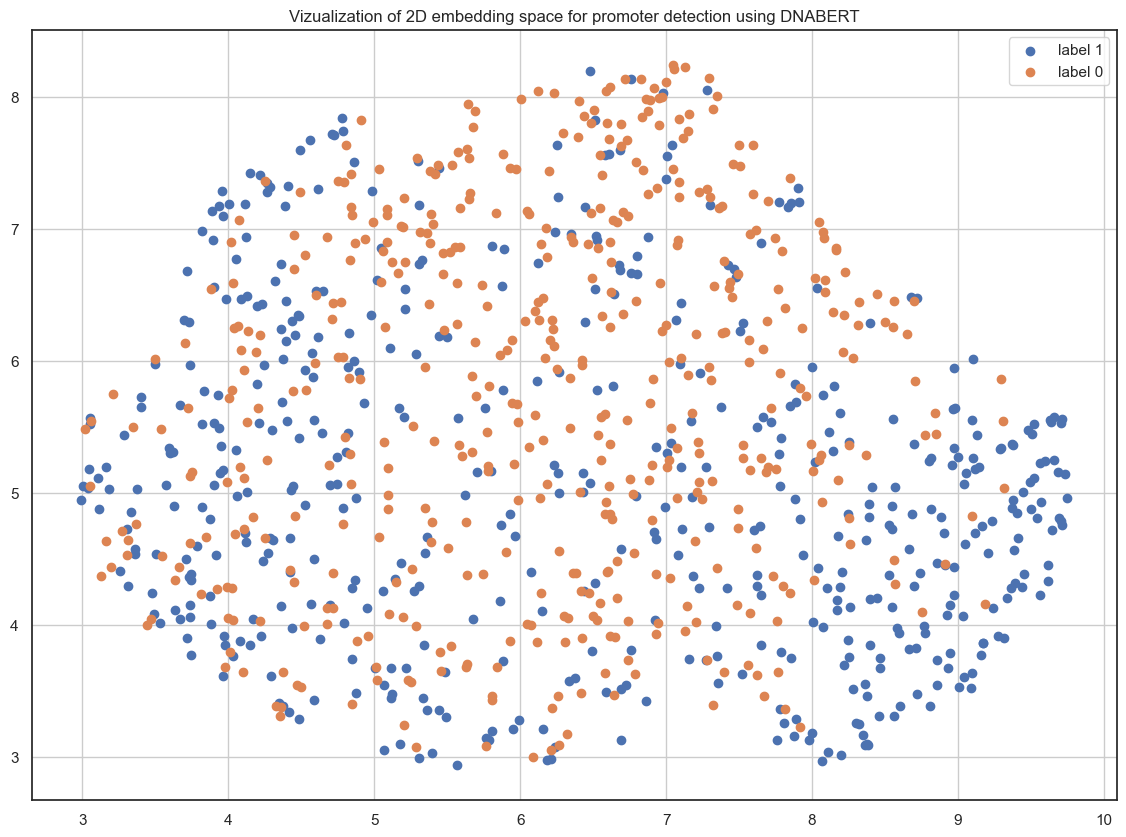

In [9]:
# ToDo: Using tsne or umap to visualize the embedding space.
# Hint: you can import other packages here for visualization.
import umap
import seaborn as sns
import matplotlib.pyplot as plt

reducer = umap.UMAP()
vizualization = reducer.fit_transform(train_embeddings)

ones_label = torch.argwhere(train_labels).squeeze(-1).tolist()
zeros_label = (train_labels == 0).nonzero().squeeze(-1).tolist()
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
plt.scatter(
    vizualization[ones_label, 0],
    vizualization[ones_label, 1], label='tab:blue')
plt.scatter(
    vizualization[zeros_label, 0],
    vizualization[zeros_label, 1], label='tab:orange'
)
plt.title("Vizualization of 2D embedding space for promoter detection using DNABERT")
plt.legend(['label 1', 'label 0'])
plt.grid(visible=True)
plt.show()

As we can se from the plot of embeddings, we don't have really convenient separation between two classes.

In [158]:
batch_size = 128
train_dataset = TensorDataset(train_embeddings, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_embeddings, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

c. Train a classifier.

Hint: It is easy to overfit on the training set. Try to avoid overfitting.

In [162]:
# Define model classifier
class classifier(nn.Module):
    """ Classifert for promoter sequence detection. """
    def __init__(self):
        super().__init__()
    
        # Linear layers
        self.layer1 = nn.Linear(768, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 1)
    
        # Activation function
        self.activation = nn.ReLU()

    def forward(self, input):
        """ Only input is the embeddings for the sequence obtained using pre-trained model. """
        # Layer 1
        output = self.layer1(input)
        output = self.activation(output)
        output = F.dropout(output, p=0.05, training=self.training)
    
        # Layer 2
        output = self.layer2(output)
        output = self.activation(output)
        output = F.dropout(output, p=0.05, training=self.training)
        
        #Layer3
        output = self.layer3(output)

        return output

In [163]:
def calculate_accuracy_dnabert(model, data_loader):
  with torch.no_grad():
        accuracy = 0

        for batch_input_ids, batch_class_labels in data_loader:

            batch = batch_input_ids.size(dim=0)
            output = model(batch_input_ids.float())
            output = output.view([batch])

            # Make prediction
            prediction = (torch.sigmoid(output) > 0.5).float()
            acc = accuracy_score(batch_class_labels.float(), prediction)
            accuracy += acc

  return accuracy / len(data_loader)

In [164]:
# Train loop
model_classifier = classifier()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model_classifier.parameters(), lr=0.001)

for epoch in range(100):

    total_train_loss = 0

    for batch_input_ids, batch_class_labels in train_loader:

        batch = batch_input_ids.size(dim=0)
        #print(batch)
        optimizer.zero_grad()

        output = model_classifier(batch_input_ids.float())
        output = output.view([batch])
        loss = loss_fn(output, batch_class_labels.float())
        #print(batch_class_labels.float())

        loss.backward()
        optimizer.step()

        # Add up to loss
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    if (epoch + 1) % 10 == 0:

        model.eval()
        total_eval_loss = 0

        for batch_input_ids, batch_class_labels in test_loader:

            batch = batch_input_ids.size(dim=0)

            with torch.no_grad():
                output = model_classifier(batch_input_ids.float())
                output = output.view([batch])
                loss = loss_fn(output, batch_class_labels.float())
                total_eval_loss += loss.item()

        avg_eval_loss = total_eval_loss / len(test_loader)
        print('Epoch:', '%04d' % (epoch + 1), 'train cost =', '{:.6f}'.format(avg_train_loss), 'eval cost =', '{:.6f}'.format(avg_eval_loss))

average_train_acc = calculate_accuracy_dnabert(model_classifier, train_loader)
average_test_acc = calculate_accuracy_dnabert(model_classifier, test_loader)
print('Train Acc =', '{:.6f}'.format(average_train_acc), 'Eval Acc =', '{:.6f}'.format(average_test_acc))

Epoch: 0010 train cost = 0.661360 eval cost = 0.673726
Epoch: 0020 train cost = 0.555745 eval cost = 0.694198
Epoch: 0030 train cost = 0.500147 eval cost = 0.750516
Epoch: 0040 train cost = 0.480306 eval cost = 0.721662
Epoch: 0050 train cost = 0.474005 eval cost = 0.760924
Epoch: 0060 train cost = 0.448237 eval cost = 0.719558
Epoch: 0070 train cost = 0.530804 eval cost = 0.808099
Epoch: 0080 train cost = 0.418012 eval cost = 0.747847
Epoch: 0090 train cost = 0.398408 eval cost = 0.716527
Epoch: 0100 train cost = 0.377539 eval cost = 0.862849
Train Acc = 0.803185 Eval Acc = 0.642353


As we can see, there is slight overfit. To try to avoid it, I tried with different approaches, from larger dropout probability to stronger regularization, but accuracy was constantly around 0.65. I also tried training on the dataset with more DNA sequences and different network arhitectures, but that was also giving me similar results. 